In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms as transforms
import numpy as np
import itertools
import os
import time
import math
import argparse
import losses
import other
from datasets.RAF import RAF_multi_teacher
from torch.autograd import Variable
from network.teacherNet import Teacher
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE as TSNE
from audtorch.metrics.functional import pearsonr
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def load_pretrained_model(model, pretrained_dict):
	model_dict = model.state_dict()
	# 1. filter out unnecessary keys
	pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
	# 2. overwrite entries in the existing state dict
	model_dict.update(pretrained_dict) 
	# 3. load the new state dict
	model.load_state_dict(model_dict)

NUM_CLASSES = 7
transform_test = transforms.Compose([
    transforms.TenCrop(92),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(
        mean=[0.589667, 0.45717254, 0.40727714], std=[0.25235596, 0.23242524, 0.23155019])
                (transforms.ToTensor()(crop)) for crop in crops])),])

PrivateTestset = RAF_multi_teacher(split = 'PrivateTest', transform=transform_test)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=32, shuffle=False, num_workers=1)
net1 = Teacher(num_classes=NUM_CLASSES).cuda()
net2 = Teacher(num_classes=NUM_CLASSES).cuda()
net3 = Teacher(num_classes=NUM_CLASSES).cuda()
net4 = Teacher(num_classes=NUM_CLASSES).cuda()

net1.eval()
net2.eval()
net3.eval()
net4.eval()

tcheckpoint = torch.load('results/RAF_MultiTeacher_OurDiversity_0.0_0.0/Best_MultiTeacher_model.t7')
load_pretrained_model(net1, tcheckpoint['Teacher1'])
load_pretrained_model(net2, tcheckpoint['Teacher2'])
load_pretrained_model(net3, tcheckpoint['Teacher3'])
load_pretrained_model(net4, tcheckpoint['Teacher4'])

for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    test_bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    with torch.no_grad():
        _, _, _, mimic1, outputs1 = net1(inputs)
        _, _, _, mimic2, outputs2 = net2(inputs)
        _, _, _, mimic3, outputs3 = net3(inputs)
        _, _, _, mimic4, outputs4 = net4(inputs)
        
    outputs1 = outputs1.view(test_bs, ncrops, -1).mean(1)
    outputs2 = outputs2.view(test_bs, ncrops, -1).mean(1) 
    outputs3 = outputs3.view(test_bs, ncrops, -1).mean(1) 
    outputs4 = outputs4.view(test_bs, ncrops, -1).mean(1)
    mimic = (outputs1+outputs2+outputs3+outputs4)/4
    
    outputs1 = F.softmax(outputs1/20,dim=1)
    outputs2 = F.softmax(outputs2/20,dim=1)
    outputs3 = F.softmax(outputs3/20,dim=1)
    outputs4 = F.softmax(outputs4/20,dim=1)
    mimic = F.softmax(mimic/20,dim=1)
    
    if batch_idx == 0:
        data1 = outputs1
        data2 = outputs2
        data3 = outputs3
        data4 = outputs4
        data = mimic
        label = targets
    else:
        data1 = torch.cat((data1,outputs1),0)
        data2 = torch.cat((data2,outputs2),0)
        data3 = torch.cat((data3,outputs3),0)
        data4 = torch.cat((data4,outputs4),0)
        data = torch.cat((data,mimic),0)
        label = torch.cat((label,targets),0)
output1 = torch.abs(data-data1).sum(1).cpu()
output2 = torch.abs(data-data2).sum(1).cpu()
output3 = torch.abs(data-data3).sum(1).cpu()
output4 = torch.abs(data-data4).sum(1).cpu()
X00 = (output1 + output2 + output3 + output4)/4

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms as transforms
import numpy as np
import itertools
import os
import time
import math
import argparse
import losses
import other
from datasets.RAF import RAF_multi_teacher
from torch.autograd import Variable
from network.teacherNet import Teacher
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE as TSNE
from audtorch.metrics.functional import pearsonr
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def load_pretrained_model(model, pretrained_dict):
	model_dict = model.state_dict()
	# 1. filter out unnecessary keys
	pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
	# 2. overwrite entries in the existing state dict
	model_dict.update(pretrained_dict) 
	# 3. load the new state dict
	model.load_state_dict(model_dict)

NUM_CLASSES = 7
transform_test = transforms.Compose([
    transforms.TenCrop(92),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(
        mean=[0.589667, 0.45717254, 0.40727714], std=[0.25235596, 0.23242524, 0.23155019])
                (transforms.ToTensor()(crop)) for crop in crops])),])

PrivateTestset = RAF_multi_teacher(split = 'PrivateTest', transform=transform_test)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=32, shuffle=False, num_workers=1)
net1 = Teacher(num_classes=NUM_CLASSES).cuda()
net2 = Teacher(num_classes=NUM_CLASSES).cuda()
net3 = Teacher(num_classes=NUM_CLASSES).cuda()
net4 = Teacher(num_classes=NUM_CLASSES).cuda()

net1.eval()
net2.eval()
net3.eval()
net4.eval()

tcheckpoint = torch.load('results/RAF_MultiTeacher_USTE/Best_MultiTeacher_model.t7')
load_pretrained_model(net1, tcheckpoint['Teacher1'])
load_pretrained_model(net2, tcheckpoint['Teacher2'])
load_pretrained_model(net3, tcheckpoint['Teacher3'])
load_pretrained_model(net4, tcheckpoint['Teacher4'])

for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    test_bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    with torch.no_grad():
        _, _, _, mimic1, outputs1 = net1(inputs)
        _, _, _, mimic2, outputs2 = net2(inputs)
        _, _, _, mimic3, outputs3 = net3(inputs)
        _, _, _, mimic4, outputs4 = net4(inputs)
        
    outputs1 = outputs1.view(test_bs, ncrops, -1).mean(1)
    outputs2 = outputs2.view(test_bs, ncrops, -1).mean(1) 
    outputs3 = outputs3.view(test_bs, ncrops, -1).mean(1) 
    outputs4 = outputs4.view(test_bs, ncrops, -1).mean(1)
    mimic = (outputs1+outputs2+outputs3+outputs4)/4
    
    outputs1 = F.softmax(outputs1/20,dim=1)
    outputs2 = F.softmax(outputs2/20,dim=1)
    outputs3 = F.softmax(outputs3/20,dim=1)
    outputs4 = F.softmax(outputs4/20,dim=1)
    mimic = F.softmax(mimic/20,dim=1)
    
    if batch_idx == 0:
        data1 = outputs1
        data2 = outputs2
        data3 = outputs3
        data4 = outputs4
        data = mimic
        label = targets
    else:
        data1 = torch.cat((data1,outputs1),0)
        data2 = torch.cat((data2,outputs2),0)
        data3 = torch.cat((data3,outputs3),0)
        data4 = torch.cat((data4,outputs4),0)
        data = torch.cat((data,mimic),0)
        label = torch.cat((label,targets),0)
output1 = torch.abs(data-data1).sum(1).cpu()
output2 = torch.abs(data-data2).sum(1).cpu()
output3 = torch.abs(data-data3).sum(1).cpu()
output4 = torch.abs(data-data4).sum(1).cpu()
X_USTE = (output1 + output2 + output3 + output4)/4

In [3]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms as transforms
import numpy as np
import itertools
import os
import time
import math
import argparse
import losses
import other
from datasets.RAF import RAF_multi_teacher
from torch.autograd import Variable
from network.teacherNet import Teacher
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE as TSNE
from audtorch.metrics.functional import pearsonr
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def load_pretrained_model(model, pretrained_dict):
	model_dict = model.state_dict()
	# 1. filter out unnecessary keys
	pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
	# 2. overwrite entries in the existing state dict
	model_dict.update(pretrained_dict) 
	# 3. load the new state dict
	model.load_state_dict(model_dict)

NUM_CLASSES = 7
transform_test = transforms.Compose([
    transforms.TenCrop(92),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(
        mean=[0.589667, 0.45717254, 0.40727714], std=[0.25235596, 0.23242524, 0.23155019])
                (transforms.ToTensor()(crop)) for crop in crops])),])

PrivateTestset = RAF_multi_teacher(split = 'PrivateTest', transform=transform_test)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=32, shuffle=False, num_workers=1)
net1 = Teacher(num_classes=NUM_CLASSES).cuda()
net2 = Teacher(num_classes=NUM_CLASSES).cuda()
net3 = Teacher(num_classes=NUM_CLASSES).cuda()
net4 = Teacher(num_classes=NUM_CLASSES).cuda()

net1.eval()
net2.eval()
net3.eval()
net4.eval()

tcheckpoint = torch.load('results/RAF_MultiTeacher_OurDiversity_0.8_9.0/Best_MultiTeacher_model.t7')
load_pretrained_model(net1, tcheckpoint['Teacher1'])
load_pretrained_model(net2, tcheckpoint['Teacher2'])
load_pretrained_model(net3, tcheckpoint['Teacher3'])
load_pretrained_model(net4, tcheckpoint['Teacher4'])

for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    test_bs, ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    with torch.no_grad():
        _, _, _, mimic1, outputs1 = net1(inputs)
        _, _, _, mimic2, outputs2 = net2(inputs)
        _, _, _, mimic3, outputs3 = net3(inputs)
        _, _, _, mimic4, outputs4 = net4(inputs)
        
    outputs1 = outputs1.view(test_bs, ncrops, -1).mean(1)
    outputs2 = outputs2.view(test_bs, ncrops, -1).mean(1) 
    outputs3 = outputs3.view(test_bs, ncrops, -1).mean(1) 
    outputs4 = outputs4.view(test_bs, ncrops, -1).mean(1)
    mimic = (outputs1+outputs2+outputs3+outputs4)/4
    
    outputs1 = F.softmax(outputs1/20,dim=1)
    outputs2 = F.softmax(outputs2/20,dim=1)
    outputs3 = F.softmax(outputs3/20,dim=1)
    outputs4 = F.softmax(outputs4/20,dim=1)
    mimic = F.softmax(mimic/20,dim=1)
    
    if batch_idx == 0:
        data1 = outputs1
        data2 = outputs2
        data3 = outputs3
        data4 = outputs4
        data = mimic
        label = targets
    else:
        data1 = torch.cat((data1,outputs1),0)
        data2 = torch.cat((data2,outputs2),0)
        data3 = torch.cat((data3,outputs3),0)
        data4 = torch.cat((data4,outputs4),0)
        data = torch.cat((data,mimic),0)
        label = torch.cat((label,targets),0)
        
output1 = torch.abs(data-data1).sum(1).cpu()
output2 = torch.abs(data-data2).sum(1).cpu()
output3 = torch.abs(data-data3).sum(1).cpu()
output4 = torch.abs(data-data4).sum(1).cpu()
X08_90 = (output1 + output2 + output3 + output4)/4

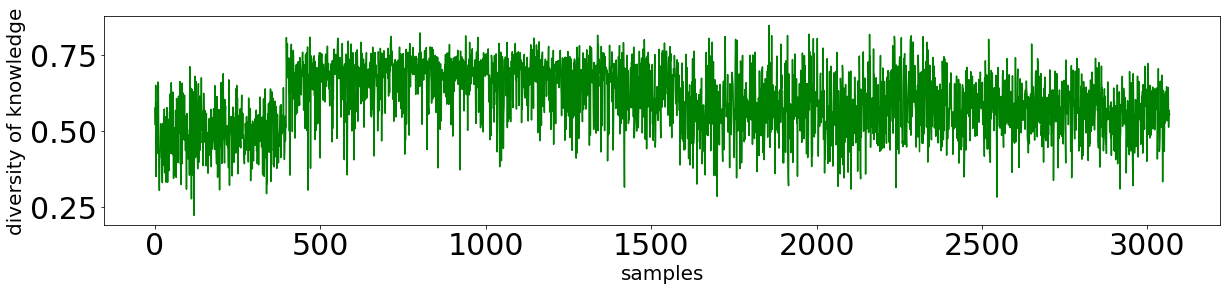

finishing training


In [4]:
import matplotlib.pyplot as plt
epochs = range(0,3068)
plt.figure(figsize=(20, 5))
plt.plot(epochs,X08_90,color='green',label='X08_90') 
plt.tick_params(labelsize=30)
plt.xlabel(r'samples', fontsize=20)
plt.ylabel('diversity of knowledge', fontsize=20)
plt.subplots_adjust(bottom=0.30)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/X08_90.jpg', dpi=500)
plt.show()
print('finishing training')

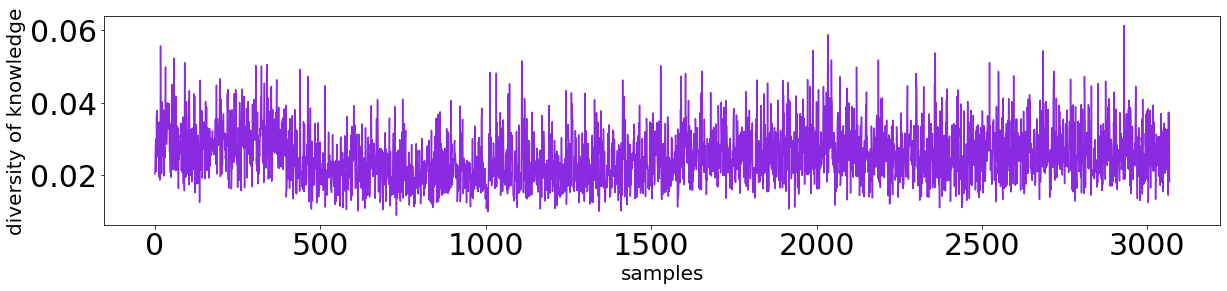

finishing training


In [5]:
import matplotlib.pyplot as plt
epochs = range(0,3068)
plt.figure(figsize=(20, 5))
plt.plot(epochs,X00,color='blueviolet',label='X00')  
plt.tick_params(labelsize=30)
plt.xlabel(r'samples', fontsize=20)
plt.ylabel('diversity of knowledge', fontsize=20)
plt.subplots_adjust(bottom=0.30)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/X00.jpg', dpi=500)
plt.show()
print('finishing training')

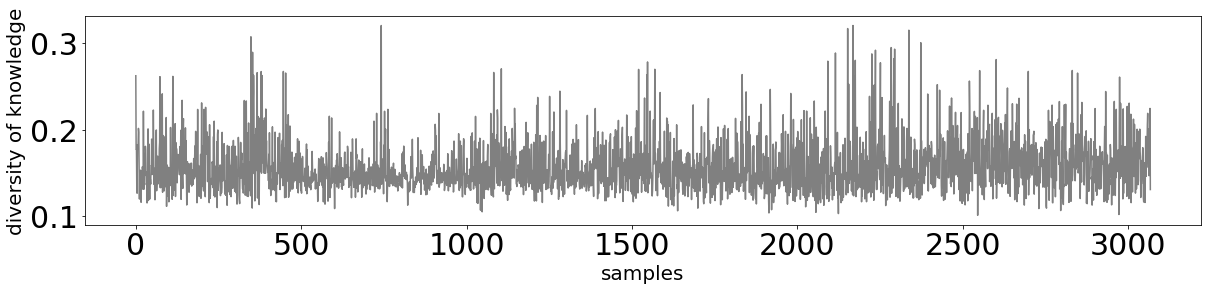

finishing training


In [6]:
import matplotlib.pyplot as plt
epochs = range(0,3068)
plt.figure(figsize=(20, 5))
plt.plot(epochs,X_USTE,color='0.5',label='X_USTE')  
plt.tick_params(labelsize=30)
plt.xlabel(r'samples', fontsize=20)
plt.ylabel('diversity of knowledge', fontsize=20)
plt.subplots_adjust(bottom=0.30)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/X_USTE.jpg', dpi=500)
plt.show()
print('finishing training')

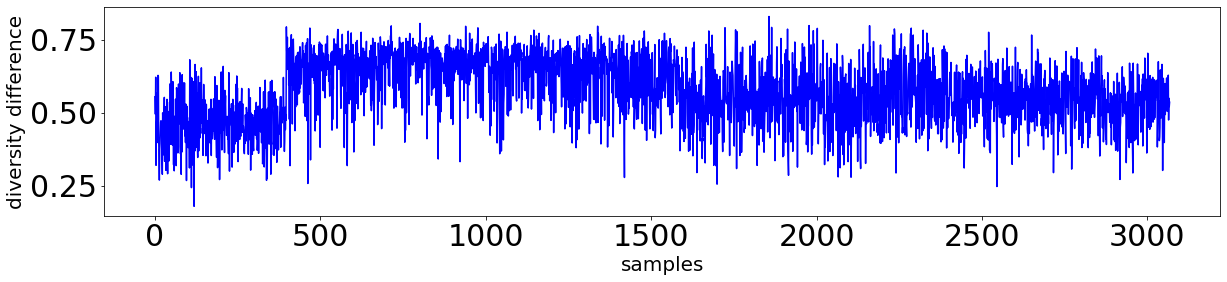

finishing training


In [7]:
X0890_00 = X08_90 - X00
import matplotlib.pyplot as plt
epochs = range(0,3068)
plt.figure(figsize=(20, 5))
plt.plot(epochs,X0890_00,color='b',label='X0890_00')  
plt.tick_params(labelsize=30)
plt.xlabel(r'samples', fontsize=20)
plt.ylabel('diversity difference', fontsize=20)
plt.subplots_adjust(bottom=0.30)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/X0890_00.jpg', dpi=500)
plt.show()
print('finishing training')

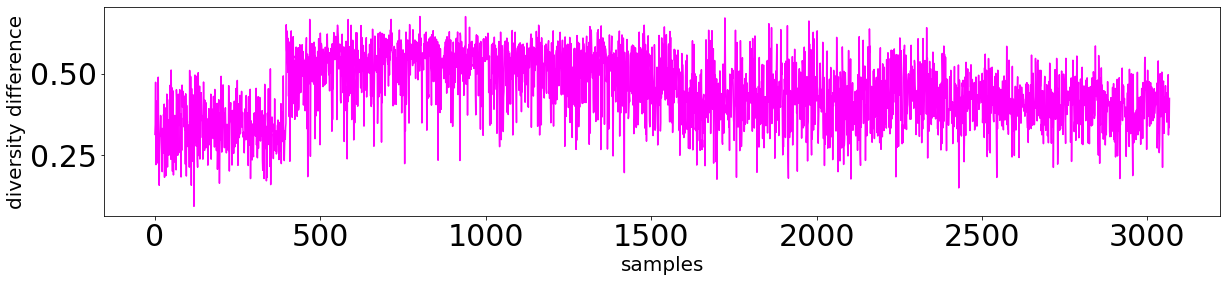

finishing training


In [8]:
X0890_USTE = X08_90 - X_USTE
import matplotlib.pyplot as plt
epochs = range(0,3068)
plt.figure(figsize=(20, 5))
plt.plot(epochs,X0890_USTE,color='#FF00FF',label='X0890_USTE')  
plt.tick_params(labelsize=30)
plt.xlabel(r'samples', fontsize=20)
plt.ylabel('diversity difference', fontsize=20)
plt.subplots_adjust(bottom=0.30)
if not os.path.isdir('picture/'):
    os.mkdir('picture/')
plt.savefig('picture/X0890_USTE.jpg', dpi=500)
plt.show()
print('finishing training')